In [178]:
#imports
import os
import scienceplots
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
from tqdm import tqdm

from mrmr import mrmr_regression

from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from torch.optim.lr_scheduler import StepLR

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
torch.manual_seed(4000)
np.random.seed(42)

In [181]:
df=pd.read_csv('C:\\Users\\lucas\\Downloads\\laohuaYM_noAvg(2).csv',header=None,skiprows=1)
df_sorted=df.sort_values(by=1845)
train_df = pd.DataFrame(columns=df.columns)
test_df = pd.DataFrame(columns=df.columns)

for i in range(len(df)):
    if (i % 5) == 4:  # Adding every 5th row to the test_df
        test_df = pd.concat([test_df, df.iloc[[i]]], ignore_index=True)
    else:  # add other rows train
        train_df = pd.concat([train_df, df.iloc[[i]]], ignore_index=True)
        
x_train=train_df.iloc[:,0:1845]
y_train=train_df.iloc[:,1845]
x_test=test_df.iloc[:,0:1845]
y_test=test_df.iloc[:,1845]
x_train=pd.DataFrame(x_train)
y_train=pd.Series(y_train.ravel())

x_test=pd.DataFrame(x_test)
y_test=pd.Series(y_test.ravel())
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
x_train=pd.DataFrame(x_train)
y_train=pd.Series(y_train.ravel())

x_test=pd.DataFrame(x_test)
y_test=pd.Series(y_test.ravel())

#### Data

In [142]:
#read data
X=pd.read_csv('.\\alternative_data_set\\X_diesel.csv',header=None)
Y=pd.read_csv('.\\alternative_data_set\\Y3_diesel.csv',header=None)

In [143]:
#remove missing values
X['target_variable']=Y[1]
X=X.dropna()
X=X.reset_index(drop=True)
Y=X.iloc[:,401]
X=X.iloc[:,:401]

In [144]:
#data split and normalisation
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [145]:
#norm
scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_test=scaler_x.transform(x_test)

scaler_y=StandardScaler()
scaler_y.fit(y_train.values.reshape(-1,1))
y_train=scaler_y.transform(y_train.values.reshape(-1,1))
y_test=scaler_y.transform(y_test.values.reshape(-1,1))

In [146]:
x_train=pd.DataFrame(x_train)
y_train=pd.Series(y_train.ravel())

x_test=pd.DataFrame(x_test)
y_test=pd.Series(y_test.ravel())

### CNN

In [182]:
###with xavier
class Inception(nn.Module):

    def __init__(self, out_channels_1, kernel_1, stride_1, out_channels_2, kernel_2, stride_2, out_channels_3, kernel_3, stride_3, hidden_size, dropout_rate, total_features):
        super(Inception, self).__init__()

        # LeakyReLU
        self.leaky_relu = nn.LeakyReLU()

        # Common conv1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels_1, kernel_size=kernel_1, stride=stride_1)
        nn.init.xavier_uniform_(self.conv1.weight)

        # Branch 1
        self.branch1_2 = nn.Conv1d(in_channels=out_channels_1, out_channels=out_channels_3, kernel_size=1, stride=1)
        nn.init.xavier_uniform_(self.branch1_2.weight)

        # Branch 2
        self.branch2_2 = nn.Conv1d(in_channels=out_channels_1, out_channels=out_channels_2, kernel_size=1, stride=1)
        nn.init.xavier_uniform_(self.branch2_2.weight)
        self.branch2_3 = nn.Conv1d(in_channels=out_channels_2, out_channels=out_channels_3, kernel_size=kernel_3, stride=stride_3)
        nn.init.xavier_uniform_(self.branch2_3.weight)

        # Branch 3
        self.branch3_2 = nn.Conv1d(in_channels=out_channels_1, out_channels=out_channels_2, kernel_size=1, stride=1)
        nn.init.xavier_uniform_(self.branch3_2.weight)
        self.branch3_3 = nn.Conv1d(in_channels=out_channels_2, out_channels=out_channels_3, kernel_size=kernel_3, stride=stride_3)
        nn.init.xavier_uniform_(self.branch3_3.weight)

        # Branch 4
        self.branch4_2 = nn.MaxPool1d(kernel_size=kernel_2, stride=stride_2)
        self.branch4_3 = nn.Conv1d(in_channels=out_channels_1, out_channels=out_channels_3, kernel_size=1, stride=1)
        nn.init.xavier_uniform_(self.branch4_3.weight)

        # Flatten
        self.flatten = nn.Flatten()

        # Layers
        self.F1 = nn.Linear(total_features, hidden_size)
        nn.init.xavier_uniform_(self.F1.weight)
        self.output = nn.Linear(hidden_size, 1)
        nn.init.xavier_uniform_(self.output.weight)

        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(total_features)
        self.bn2 = nn.BatchNorm1d(hidden_size)

        # Dropout
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        origin = self.leaky_relu(self.conv1(x))

        branch1 = self.leaky_relu(self.branch1_2(origin))
        branch2 = self.leaky_relu(self.branch2_3(self.leaky_relu(self.branch2_2(origin))))
        branch3 = self.leaky_relu(self.branch3_3(self.leaky_relu(self.branch3_2(origin))))
        branch4 = self.leaky_relu(self.branch4_3(self.branch4_2(origin)))

        # Flatten each branch output
        flat_branch1 = self.flatten(branch1)
        flat_branch2 = self.flatten(branch2)
        flat_branch3 = self.flatten(branch3)
        flat_branch4 = self.flatten(branch4)

        # Concatenate the flattened branches
        concat = torch.cat([flat_branch1, flat_branch2, flat_branch3, flat_branch4], dim=1)

        F1_out = self.leaky_relu(self.bn2(self.F1(concat)))
        F1_out = self.dropout(F1_out)

        output = self.output(F1_out)

        return output

#### CNN Support functions

In [183]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [184]:
# Adjust make_loader to ensure the data has the correct shape
def make_loader(X, y, batch):
    if not isinstance(X, pd.DataFrame):
        try:
            X = pd.DataFrame(X)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y, pd.Series):
        try:
            y = pd.Series(y)
        except ValueError:
            print("y cannot be converted to a pandas Series.")        
    
    # Ensure the input tensor has the shape (batch_size, channels, sequence_length)
    x_tensor = torch.tensor(X.values, dtype=torch.float32).unsqueeze(1)  # Adding channel dimension
    y_tensor = torch.tensor(y.values, dtype=torch.float32)
    set_object = TensorDataset(x_tensor, y_tensor)
    loader_object = DataLoader(dataset=set_object, batch_size=batch)
    return loader_object


In [185]:
def r2_score_model(model, loader):
    model.eval()  # Set model to evaluation mode
    true_values = []
    predictions = []
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in loader:
            outputs = model(inputs)  # Get model predictions
            predictions.extend(outputs.cpu().numpy())  # Move to CPU and store predictions
            true_values.extend(labels.cpu().numpy())  # Move to CPU and store true labels
    
    # Calculate R^2 score
    return r2_score(true_values, predictions)

In [186]:
#evaluate once
def evaluate(Loader, model, loss_fn):
    model.eval()
    loss_sum=0
    with torch.no_grad():
        for batch, (X,y) in enumerate(Loader):
            pred=model(X)
            loss=loss_fn(pred,y.unsqueeze(1))
            loss_sum+=loss.item()
            
    loss_sum/=len(Loader)
    
    return loss_sum

In [187]:
#train a single epoch
def train_one_epoch(TrainLoader, model, loss_fn, optimizer):
    model.train() 
    #train for every example in the dataloader
    for X_train,y_train in TrainLoader:
            
        pred_train=model(X_train)
        loss_train=loss_fn(pred_train,y_train.unsqueeze(1))
            
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    return model

In [188]:
#train and store all errors =)
def train_with_err(TrainLoader, TestLoader, model, loss_fn, optimizer,epochs):
    train_loss_epochs=[]
    test_loss_epochs=[]
    
    model.train() 
    
    for epoch in range(epochs):
        #train for every example in the dataloader
        model=train_one_epoch(TrainLoader=TrainLoader, model=model, loss_fn=loss_fn, optimizer=optimizer)
    
        loss_train_curr_epoch=evaluate(TrainLoader,model,loss_fn)
        train_loss_epochs.append(loss_train_curr_epoch)
       
        loss_test_curr_epoch=evaluate(TestLoader,model,loss_fn)
        test_loss_epochs.append(loss_test_curr_epoch)
        
    return model, train_loss_epochs, test_loss_epochs

In [189]:
#train and store all errors =)
def train(TrainLoader, model, loss_fn, optimizer,num_epochs):
    
    model.train() 
    
    for epoch in range(num_epochs):
        #train for every example in the dataloader
        model=train_one_epoch(TrainLoader=TrainLoader, model=model, loss_fn=loss_fn, optimizer=optimizer)
        
    return model

In [190]:
def ini_model(learning_rate, out_channels_1, kernel_1,
              stride_1, out_channels_2, kernel_2, stride_2, out_channels_3,
              kernel_3, stride_3, hidden_size, dropout_rate, total_features, regularization_coeff):
    set_seed(42)

    model = Inception(out_channels_1=out_channels_1,
                      kernel_1=kernel_1,
                      stride_1=stride_1,
                      out_channels_2=out_channels_2,
                      kernel_2=kernel_2,
                      stride_2=stride_2,
                      out_channels_3=out_channels_3,
                      kernel_3=kernel_3,
                      stride_3=stride_3,
                      hidden_size=hidden_size,
                      dropout_rate=dropout_rate,
                      total_features=total_features)

    # Apply Xavier initialization to the model parameters
    def init_weights(m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    model.apply(init_weights)

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=regularization_coeff)

    return model, loss_fn, optimizer

### Benchmark

In [194]:
out_channels_1=4
out_channels_2=2
out_channels_3=4

kernel_1=80
kernel_2=5
kernel_3=24
stride_1=15
stride_2=3
stride_3=1#
hidden_size=30
batch_size=1000
dropout_rate=0.1
regularization_coeff=0.0001
learning_rate=0.0001
lr_decay=0.001

In [195]:
features_ini=x_train.shape[1]

branch1=(features_ini-kernel_1)//stride_1+1
branch1=(branch1-1)//1+1
branch1=branch1*out_channels_3

branch2=(features_ini-kernel_1)//stride_1+1
branch2=(branch2-1)//1+1
branch2=(branch2-kernel_3)//stride_3+1
branch2=branch2*out_channels_3

branch3=(features_ini-kernel_1)//stride_1+1
branch3=(branch3-1)//1+1
branch3=(branch3-kernel_3)//stride_3+1
branch3=branch3*out_channels_3

branch4=(features_ini-kernel_1)//stride_1+1
branch4=(branch4-kernel_2)//stride_2+1
branch4=(branch4-1)//1+1
branch4=branch4*out_channels_3

total_features = branch1 + branch2 + branch3 + branch4

In [196]:
total_features

1384

In [197]:
train_loader=make_loader(X=x_train,y=y_train,batch=batch_size)
test_loader=make_loader(X=x_test,y=y_test,batch=batch_size)

epochs=300

model,loss_fn,optimizer=ini_model(learning_rate,
                                         out_channels_1,
                                         kernel_1,
                                         stride_1,
                                         out_channels_2,
                                         kernel_2,
                                         stride_2,
                                         out_channels_3,
                                         kernel_3,
                                         stride_3,
                                         hidden_size,
                                         dropout_rate,
                                         total_features,
                                         regularization_coeff)

In [160]:
model, train_loss, test_loss=train_with_err(TrainLoader=train_loader, 
                                              TestLoader=test_loader,
                                              model=model,
                                              loss_fn=loss_fn,
                                              optimizer=optimizer,
                                              epochs=2000)

In [198]:
model=train(TrainLoader=train_loader,
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            num_epochs=2000)

In [200]:
r2=r2_score_model(model,train_loader)
r2

0.8895583509464877

In [202]:
r2=evaluate(train_loader,model,loss_fn)
r2

0.01164986751973629

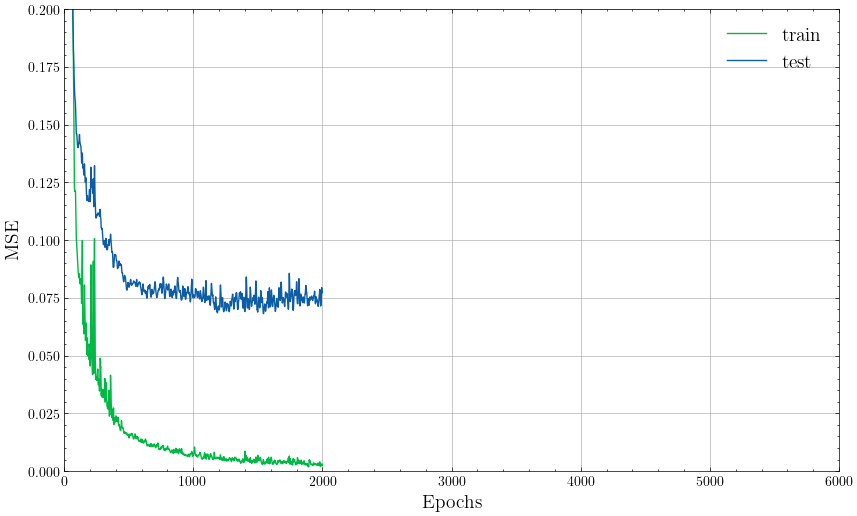

In [162]:
import scienceplots
plt.style.use('science')
plt.figure(figsize=(10,6))

plt.plot(np.arange(len(train_loss)),train_loss,label='train',color='C1')
plt.plot(np.arange(len(test_loss)),test_loss,label='test',color='C0')
#plt.axvline(x=parou_no,color='orange',label='early stop')
plt.legend(fontsize=14)
plt.xlim(0,6000)
plt.ylim(0,0.2)


plt.xlabel('Epochs',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.grid()


#plt.savefig('C:\\Users\\lucas\\Downloads\\feature_selec_learning_curve_diff.pdf', format='pdf', bbox_inches='tight')

### CV 

In [ ]:
def CNN_CV(X_train,y_train,k_folds,batch,epochs,
                                         learning_rate,
                                         out_channels_1,
                                         kernel_1,
                                         stride_1,
                                         out_channels_2,
                                         kernel_2,
                                         stride_2,
                                         out_channels_3,
                                         kernel_3,
                                         stride_3,
                                         hidden_size,
                                         dropout_rate,
                                         total_features,
                                         regularization_coeff):
     
               
    kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)

    r2_list=[]
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        
        x_train_fold=X_train.iloc[np.sort(train_idx)]
        y_train_fold=y_train.iloc[np.sort(train_idx)]
        x_val_fold=X_train.iloc[np.sort(val_idx)]
        y_val_fold=y_train.iloc[np.sort(val_idx)]
        
        train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=batch)
        test_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=batch)

        model,loss_fn,optimizer=ini_model(learning_rate,
                                         out_channels_1,
                                         kernel_1,
                                         stride_1,
                                         out_channels_2,
                                         kernel_2,
                                         stride_2,
                                         out_channels_3,
                                         kernel_3,
                                         stride_3,
                                         hidden_size,
                                         dropout_rate,
                                         total_features,
                                         regularization_coeff) #epochs defined inside function
        
        model=train(TrainLoader=train_loader_fold,
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            num_epochs=epochs)
        
        r2=r2_score_model(model,test_loader_fold)
        r2_list.append(r2)
        
        
    return r2_list

In [ ]:
def CNN_CV_mse(X_train,y_train,k_folds,batch,epochs,
                                         learning_rate,
                                         out_channels_1,
                                         kernel_1,
                                         stride_1,
                                         out_channels_2,
                                         kernel_2,
                                         stride_2,
                                         out_channels_3,
                                         kernel_3,
                                         stride_3,
                                         hidden_size,
                                         dropout_rate,
                                         total_features,
                                         regularization_coeff):
     
               
    kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)

    mse_list=[]
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        
        x_train_fold=X_train.iloc[np.sort(train_idx)]
        y_train_fold=y_train.iloc[np.sort(train_idx)]
        x_val_fold=X_train.iloc[np.sort(val_idx)]
        y_val_fold=y_train.iloc[np.sort(val_idx)]
        
        train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=batch)
        test_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=batch)

        model,loss_fn,optimizer=ini_model(learning_rate,
                                         out_channels_1,
                                         kernel_1,
                                         stride_1,
                                         out_channels_2,
                                         kernel_2,
                                         stride_2,
                                         out_channels_3,
                                         kernel_3,
                                         stride_3,
                                         hidden_size,
                                         dropout_rate,
                                         total_features,
                                         regularization_coeff) #epochs defined inside function
        
        model=train(TrainLoader=train_loader_fold,
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            num_epochs=epochs)
        
        mse=evaluate(Loader=test_loader_fold,model=model,loss_fn=loss_fn)
        mse_list.append(mse)
        
    return mse_list

In [ ]:
def CNN_CV_repeat(X_train,y_train,k_folds,batch,epochs,
                                         learning_rate,
                                         out_channels_1,
                                         kernel_1,
                                         stride_1,
                                         out_channels_2,
                                         kernel_2,
                                         stride_2,
                                         out_channels_3,
                                         kernel_3,
                                         stride_3,
                                         hidden_size,
                                         dropout_rate,
                                         total_features,
                                         regularization_coeff,
                                         this):
     
    kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)

    r2_list=[]
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        
        x_train_fold=X_train.iloc[np.sort(train_idx)]
        y_train_fold=y_train.iloc[np.sort(train_idx)]
        x_val_fold=X_train.iloc[np.sort(val_idx)]
        y_val_fold=y_train.iloc[np.sort(val_idx)]
        
        train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=batch)
        test_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=batch)

        model,loss_fn,optimizer=ini_model(learning_rate,
                                         out_channels_1,
                                         kernel_1,
                                         stride_1,
                                         out_channels_2,
                                         kernel_2,
                                         stride_2,
                                         out_channels_3,
                                         kernel_3,
                                         stride_3,
                                         hidden_size,
                                         dropout_rate,
                                         total_features,
                                         regularization_coeff) #epochs defined inside function
        
        model=train(TrainLoader=train_loader_fold,
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            num_epochs=epochs)
        
        r2=r2_score_model(model,test_loader_fold)
        r2_list.append(r2)
        
        
    return r2_list

In [ ]:
def calculate_total_features(features_ini, kernel_1, stride_1, kernel_2, stride_2, kernel_3, stride_3, out_channels_3):
    branch1 = (features_ini - kernel_1) // stride_1 + 1
    branch1 = (branch1 - 1) // 1 + 1
    branch1 = branch1 * out_channels_3
    
    branch2 = (features_ini - kernel_1) // stride_1 + 1
    branch2 = (branch2 - 1) // 1 + 1
    branch2 = (branch2 - kernel_3) // stride_3 + 1
    branch2 = branch2 * out_channels_3
    
    branch3 = (features_ini - kernel_1) // stride_1 + 1
    branch3 = (branch3 - 1) // 1 + 1
    branch3 = (branch3 - kernel_3) // stride_3 + 1
    branch3 = branch3 * out_channels_3
    
    branch4 = (features_ini - kernel_1) // stride_1 + 1
    branch4 = (branch4 - kernel_2) // stride_2 + 1
    branch4 = (branch4 - 1) // 1 + 1
    branch4 = branch4 * out_channels_3
    
    total_features = branch1 + branch2 + branch3 + branch4
    
    return total_features

In [ ]:
from sklearn.model_selection import ParameterGrid
import numpy as np

def grid_search(X_train, y_train, k_folds, param_grid):
    best_params = None
    best_score = float('-inf')
    best_r2_list = None
    
    for params in tqdm(ParameterGrid(param_grid)):
        features_ini = X_train.shape[1]
        total_features = calculate_total_features(
            features_ini, params['kernel_1'], params['stride_1'], 
            params['kernel_2'], params['stride_2'], 
            params['kernel_3'], params['stride_3'], 
            params['out_channels_3']
        )
        
        
        r2_list=CNN_CV_mse(X_train=X_train,
            y_train=y_train,
            k_folds=k_folds,
            batch=params['batch'],
            epochs=params['epochs'],
            learning_rate=params['learning_rate'],
            out_channels_1=params['out_channels_1'],
            kernel_1=params['kernel_1'],
            stride_1=params['stride_1'],
            out_channels_2=params['out_channels_2'],
            kernel_2=params['kernel_2'],
            stride_2=params['stride_2'],
            out_channels_3=params['out_channels_3'],
            kernel_3=params['kernel_3'],
            stride_3=params['stride_3'],
            hidden_size=params['hidden_size'],
            dropout_rate=params['dropout_rate'],
            total_features=total_features,
            regularization_coeff=params['regularization_coeff'])


        mean_r2 = np.mean(r2_list)
        
        if mean_r2 > best_score:
            best_score = mean_r2
            best_params = params
            best_r2_list = r2_list
    
    return best_params, best_score, best_r2_list


In [ ]:
from sklearn.model_selection import ParameterGrid
import numpy as np

def grid_search_repeat(X_train, y_train, k_folds, param_grid,test_these):
    best_params = None
    best_score = float('-inf')
    best_r2_list = None
    
    for params in tqdm(ParameterGrid(param_grid)):
        features_ini = X_train.shape[1]
        total_features = calculate_total_features(
            features_ini, params['kernel_1'], params['stride_1'], 
            params['kernel_2'], params['stride_2'], 
            params['kernel_3'], params['stride_3'], 
            params['out_channels_3']
        )
        
        for this in tqdm(test_these):
            r2_list=CNN_CV_repeat(X_train=X_train,
                y_train=y_train,
                k_folds=k_folds,
                batch=params['batch'],
                epochs=params['epochs'],
                learning_rate=params['learning_rate'],
                out_channels_1=params['out_channels_1'],
                kernel_1=params['kernel_1'],
                stride_1=params['stride_1'],
                out_channels_2=params['out_channels_2'],
                kernel_2=params['kernel_2'],
                stride_2=params['stride_2'],
                out_channels_3=params['out_channels_3'],
                kernel_3=params['kernel_3'],
                stride_3=params['stride_3'],
                hidden_size=params['hidden_size'],
                dropout_rate=params['dropout_rate'],
                total_features=total_features,
                regularization_coeff=params['regularization_coeff'],
                this=this)


            mean_r2 = np.mean(r2_list)
            
            if mean_r2 > best_score:
                best_score = mean_r2
                best_params = params
                best_r2_list = r2_list
                this_is_best=this
    
    return best_params, best_score, best_r2_list, this_is_best


In [ ]:
# Define the parameter grid
param_grid = {
    'out_channels_1': [6],
    'out_channels_2': [4],
    'out_channels_3': [4],
    'kernel_1': [7],
    'kernel_2': [5], 
    'kernel_3': [7],
    'stride_1': [3],
    'stride_2': [3],
    'stride_3': [1],
    'hidden_size': [40],
    'batch': [1000],
    'dropout_rate': [0.25],
    'regularization_coeff': [0.0001],
    'learning_rate': [0.0001],
    'epochs': [2000] 
}

In [ ]:
best_params, best_score, best_r2_list = grid_search(X_train=x_train,
                                                    y_train=y_train,
                                                    k_folds=5,
                                                    param_grid=param_grid)

print("Best Parameters:", best_params)
print("Best Score:", best_score)

In [ ]:
best_r2_list

In [ ]:
best_params, best_score, best_r2_list, thin_one=grid_search_repeat(X_train=x_train,
                                                    y_train=y_train,
                                                    k_folds=5,
                                                    param_grid=param_grid,
                                                    test_these=[9000,9001,9002,9003,9004,9006,9007])

In [ ]:
thin_one

In [ ]:
best_params, best_score, best_r2_list=grid_search_mse(X_train=x_train, y_train=y_train, k_folds=0, param_grid=param_grid,x_test=x_test,y_test=y_test)

print("Best Parameters:", best_params)

In [ ]:
best_score

In [ ]:
r2_train, train_loss_fold, val_loss_fold=CNN_CV(X_train=x_train,
                                                              y_train=y_train
                                                              ,k_folds=5
                                                              ,batch=batch_size
                                                              ,epochs=2000,
                                         learning_rate=learning_rate,
                                         out_channels_1=out_channels_1,
                                         kernel_1=kernel_1,
                                         stride_1=stride_1,
                                         out_channels_2=out_channels_2,
                                         kernel_2=kernel_2,
                                         stride_2=stride_2,
                                         out_channels_3=out_channels_3,
                                         kernel_3=kernel_3,
                                         stride_3=stride_3,
                                         hidden_size=hidden_size,
                                         dropout_rate=dropout_rate,
                                         total_features=total_features,
                                         regularization_coeff=regularization_coeff)

In [ ]:
r2_train

In [ ]:
#loss plots on different folds
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns

# flat so i can use indexing
axs_flat = axs.flatten()

for i in range(5):
    # Plot on subplot i
    axs_flat[i].plot(np.arange(len(train_loss_list[i])), train_loss_list[i], label='Train')
    axs_flat[i].plot(np.arange(len(val_loss_list[i])), val_loss_list[i], label='Validation')
    axs_flat[i].legend()
    axs_flat[i].set_title(f'Series {i+1}')
    axs_flat[i].set_ylim([0, 0.8])

# Hide the last subplot as it's unused
axs_flat[-1].axis('off')

plt.tight_layout()
plt.show()